# 分布式计算

从单机多卡拓展
- 数据放在分布式文件体统上（不是机器本地的硬盘）
- 通过网络读取数据
- 多个worker
- 通过网络发送
- 多个参数服务器

GPU架构：
- GPU之间有交换器，交换速度不错
- CPU和GPU之间交换速度就会慢很多
- CPU和交换机（与其他CPU）交换就更更更慢

层次的参数服务器
- 使用server
- 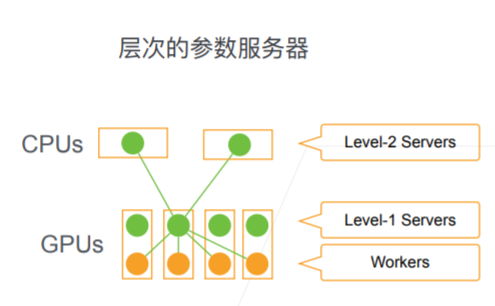
- 整体工作流程
  - 每个 Worker 使用各自的数据和 GPU 计算梯度
  - 一级服务器从多个 Workers 收集梯度数据并进行初步汇总
  - 二级服务器进一步汇总所有一级服务器的梯度，计算最终的更新后的参数
  - 更新后的参数逐层传递回所有 Workers，使得每个 Worker 的模型参数保持同步
- 优势
  - 减少通信开销
  - 高效参数同步

计算一个小批量
- 每个计算服务器读取小批量中的一块
- 进一步将数据切分到每个GPU上
- 每个worker从参数服务器那里获取模型参数
- 复制参数到每个GPU上
- 每个GPU计算梯度
- 将所有GPU上的梯度求和
- 梯度传回服务器
- 每个服务器对梯度求和，并更新参数

同步SGD
- 这里每个worker都是同步计算一个批量，称为同步SGD
- 假设有$n$个GPU，每个GPU每次处理$b$个样本，那么同步SGD等价于在单GPU上运行批量大小为$nb$的SGD
- 在理想情况下，$n$个GPU可以得到相对单个GPU的$n$倍加速

性能：
- $t_1$=在单GPU上计算$b$个样本梯度的时间
- 假设有$m$个参数，一个worker每次发送和接收$m$个参数，梯度
  - $t_2$=发送和接收所用时间
- 每个批量的计算时间为$\max(t_1, t_2)$
  - 选取足够大的$b$使得$t_1 > t_2$（$t_2$不会变）
  - 增加$b$或$n$导致更大的批量大小，导致需要更多计算来得到给定的模型精度

性能的权衡
- 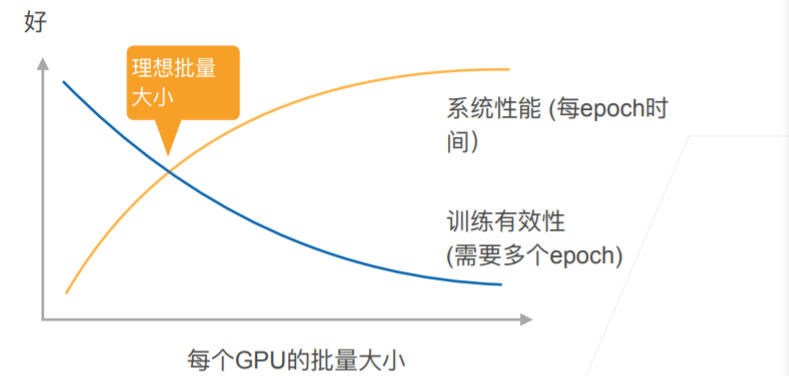

实践时的建议
- 使用一个大数据集
- 需要好的GPU-CPU和机器-机器带宽
- 高效的数据读取和预处理
- 模型需要有好的计算（FLOP）通讯（model size）比
  - Inception>ResNet>AlexNet
- 使用足够大的批量大小来得到更好的系统性能
- 使用高效的优化算法对应大批量大小

### 总结
- 分布式同步数据并行是多GPU数据并行在多机器上的拓展
- 网络通讯通常是瓶颈
- 需要注意使用特别大的批量大小时的**收敛效率**
- 更复杂的分布式有异步、模型并行


1. 参数服务器
  - 核心思想：参数服务器允许多台机器（或多GPU）通过‘push’和‘pull’操作进行参数的更新和同步
  - 作用：主要用于管理和同步大规模模型的参数，确保各个计算节点的模型一致性，并避免通信瓶颈
2. 数据并行训练
  - 数据并行策略
  - 梯度聚合策略：典型，将所有GPU的梯度在某个GPU上进行汇总，然后再将更新后的参数广播到其他GPU
  - 灵活的聚合方式；可以在不同的设备（如 CPU 或 GPU）上进行梯度汇总，甚至将梯度划分成多个部分，分别在不同的 GPU 上进行聚合，目的是在不同的硬件架构下实现最优性能
3. 硬件带宽和通信开销的优化
  - 硬件带宽限制：不同的硬件连接方式（如 NVLink、PCIe、以太网）带宽差异巨大，从而影响了参数同步的效率
  - 分布式同步策略的选择：可以将梯度划分成多个部分并在不同的 GPU 上并行聚合，利用多条链路并发传输的特性，进一步减少通信时间
4. 环同步
  - 在具有多条高速 NVLink 连接的服务器上，环同步是常用的梯度同步策略
  - 环同步策略：将所有计算节点（如 GPU）构成一个环形结构，每个节点在同步梯度时只与相邻节点通信。通过将梯度分成多个块并逐块传递，通信开销可以与节点数无关
  - 优势：环同步使得即使随着节点数量增加，聚合梯度所需时间也不会线性增加，适合于多 GPU 设备的同步
5. 多级训练的挑战和解决方案
  - 挑战：涉及多台机器时，不同机器间带宽较低，导致跨机器的通信成为瓶颈。此外，不同机器的处理速度可能不一致，这需要同步机制的协调
  - 分布式梯度同步：多机训练中通常使用参数服务器来汇总每个机器的梯度。步骤包括：每台机器的 GPU 聚合梯度 -> 汇总到本地 CPU -> 各机器的 CPU 将梯度传输到中央参数服务器 -> 参数服务器更新参数并广播
  - 多参数服务器架构：为解决单个参数服务器的带宽瓶颈问题，可以引入多个参数服务器，每个服务器只管理一部分参数，从而提升通信带宽的利用率并增强可扩展性
6. 键值存储（key-value store）抽象
  - 键值存储抽象用于简化分布式训练的复杂性。梯度更新可以通过“Push”和“Pull”操作来完成，隐藏底层的通信和同步细节